**Задача 2.** Рекуррентный автоэнкодер для кодирования и декодирования временных рядов: Создание рекуррентного автоэнкодера, предназначенного для обработки и восстановления данных временных рядов, таких как финансовые показатели или сенсорные данные.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Датасет с сайта Kaggle https://www.kaggle.com/datasets/camnugent/sandp500?select=all_stocks_5yr.csv

In [4]:
#Загрузка файла
from google.colab import files

uploaded = files.upload()

Saving all_stocks_5yr.csv to all_stocks_5yr.csv


In [5]:
data = pd.read_csv('all_stocks_5yr.csv')
print(data.head(40))

          date   open   high    low  close    volume Name
0   2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1   2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2   2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3   2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4   2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
5   2013-02-15  13.93  14.61  13.93  14.50  15628000  AAL
6   2013-02-19  14.33  14.56  14.08  14.26  11354400  AAL
7   2013-02-20  14.17  14.26  13.15  13.33  14725200  AAL
8   2013-02-21  13.62  13.95  12.90  13.37  11922100  AAL
9   2013-02-22  13.57  13.60  13.21  13.57   6071400  AAL
10  2013-02-25  13.60  13.76  13.00  13.02   7186400  AAL
11  2013-02-26  13.14  13.42  12.70  13.26   9419000  AAL
12  2013-02-27  13.28  13.62  13.18  13.41   7390500  AAL
13  2013-02-28  13.49  13.63  13.39  13.43   6143600  AAL
14  2013-03-01  13.37  13.95  13.32  13.61   7376800  AAL
15  2013-03-04  13.50  14.07  13.47  13.90   8174800  AAL
16  2013-03-05

In [6]:
# Будем работать только с акциями фирмы Apple
apple_data = data[data['Name'] == 'AAPL'][['close']].values

#Стандартизация данных
scaler = MinMaxScaler()
apple_data_scaled = scaler.fit_transform(apple_data)

#Разделение на тренировочную и тестовую выборку (80 на 20)
train_size = int(len(apple_data_scaled) * 0.8)
train_data, test_data = apple_data_scaled[:train_size], apple_data_scaled[train_size:]

In [7]:
print(apple_data)

[[ 67.8542]
 [ 68.5614]
 [ 66.8428]
 ...
 [156.49  ]
 [163.03  ]
 [159.54  ]]


In [8]:
#Преобразования одномерного массива данных в набор последовательностей
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 30
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Добавляем размерность для LSTM (batch_size, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

latent_dim = 64

# Энкодер
encoder_inputs = Input(shape=(seq_length, 1))
encoder_lstm = LSTM(latent_dim, return_sequences=False)(encoder_inputs)
encoder_model = Model(encoder_inputs, encoder_lstm, name="encoder")

# Декодер
decoder_inputs = RepeatVector(seq_length)(encoder_lstm)
decoder_lstm = LSTM(latent_dim, return_sequences=True)(decoder_inputs)
decoder_outputs = TimeDistributed(Dense(1))(decoder_lstm)
decoder_model = Model(encoder_inputs, decoder_outputs, name="decoder")

# Автоэнкодер
autoencoder = Model(encoder_inputs, decoder_outputs, name="autoencoder")
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0538 - val_loss: 0.0294
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - val_loss: 0.0118
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - val_loss: 0.0060
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - val_loss: 0.0150
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.7196e-04 - val_loss: 0.0155
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.1043e-04 - val_loss: 0.0134
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6133e-04 - val_loss: 0.0141
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0644e-04 - val_loss: 0.0130
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4514e-04 - val_loss: 0.0110
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.8420e-04 - val_loss: 0.0100
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.1235e-04 - val_loss: 0.0108
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━

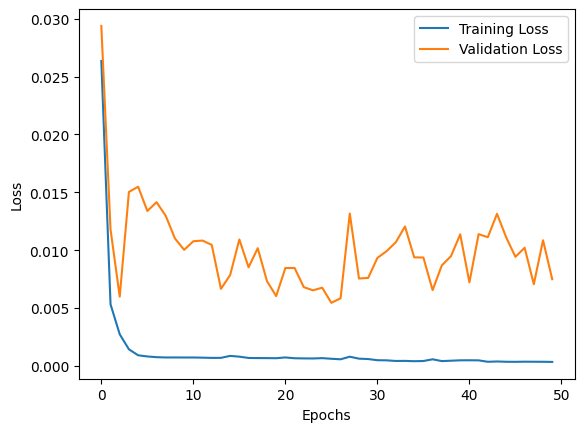

In [10]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, X_test),
    verbose=1
)

# Визуализация
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


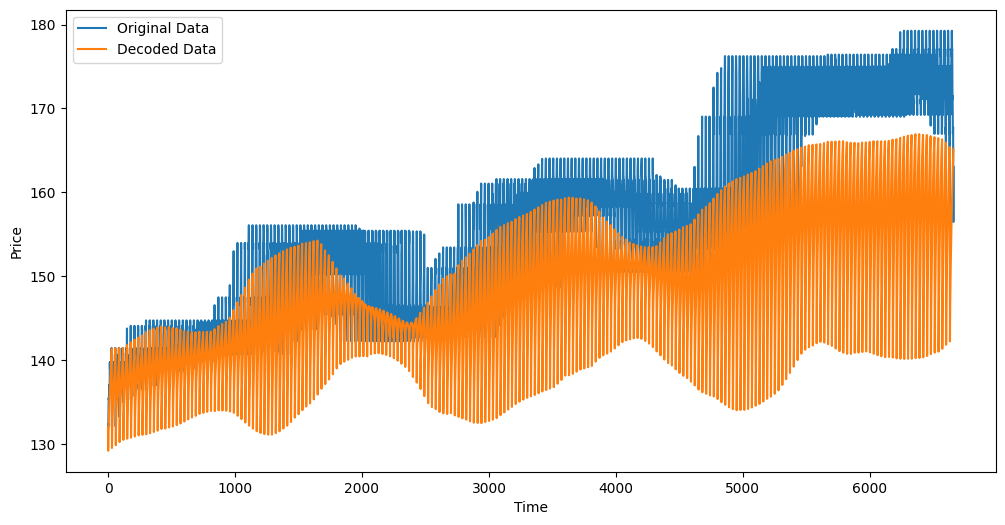

In [11]:
# Предсказание на тестовых данных
decoded_data = autoencoder.predict(X_test)


decoded_data = scaler.inverse_transform(decoded_data.reshape(-1, 1))
original_data = scaler.inverse_transform(X_test.reshape(-1, 1))

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(original_data, label='Original Data')
plt.plot(decoded_data, label='Decoded Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

**ВЫВОД** Сильное переобучение. Будем менять  размерность латентного пространства, добавлять слои Dropout и добавим раннюю остановку.


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 30, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30, 16)              │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 1)               │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,281 (12.82 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0619 - val_loss: 0.1141
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0168 - val_loss: 0.0554
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112 - val_loss: 0.0262
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0091 - val_loss: 0.0216
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0081 - val_loss: 0.0166
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0068 - val_loss: 0.0225
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0060 - val_loss: 0.0332
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0055 - val_loss: 0.0335
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0050 - val_loss: 0.0302
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0045 - val_loss: 0.0376
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - val_loss: 0.0345
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

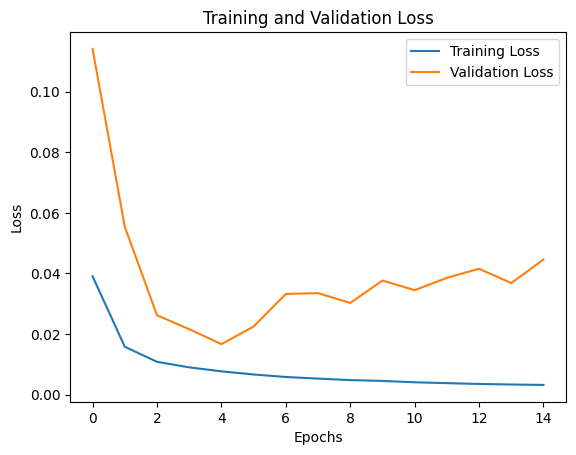

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


latent_dim = 16
seq_length = 30
dropout_rate = 0.2

# Энкодер
encoder_inputs = Input(shape=(seq_length, 1))
encoder_lstm = LSTM(latent_dim, return_sequences=False)(encoder_inputs)
encoder_lstm = Dropout(dropout_rate)(encoder_lstm)
encoder_model = Model(encoder_inputs, encoder_lstm, name="encoder")

# Декодер
decoder_inputs = RepeatVector(seq_length)(encoder_lstm)
decoder_lstm = LSTM(latent_dim, return_sequences=True)(decoder_inputs)
decoder_lstm = Dropout(dropout_rate)(decoder_lstm)
decoder_outputs = TimeDistributed(Dense(1))(decoder_lstm)

# Автоэнкодер
autoencoder = Model(encoder_inputs, decoder_outputs, name="autoencoder")
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)

# Визуализация
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

***Всё ещё переобучение***


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 30, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 30, 1)               │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 789,761 (3.01 MB)

 Trainable params: 789,761 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 3.1012 - val_loss: 0.8972
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5969 - val_loss: 0.1417
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0803 - val_loss: 0.0235
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0133 - val_loss: 0.0197
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0066 - val_loss: 0.0272
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0051 - val_loss: 0.0193
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044 - val_loss: 0.0230
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - val_loss: 0.0339
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0046 - val_loss: 0.0193
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - val_loss: 0.0401
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0242
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

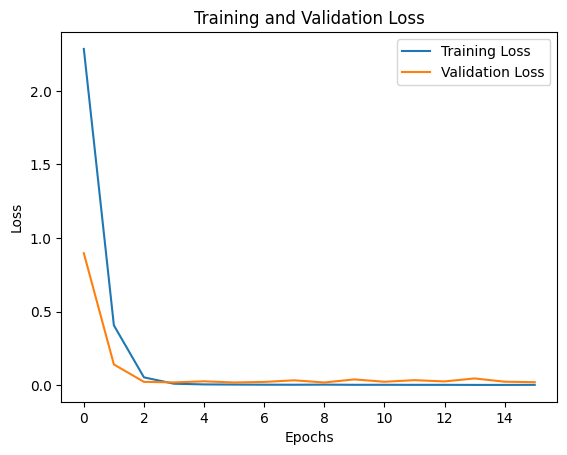

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


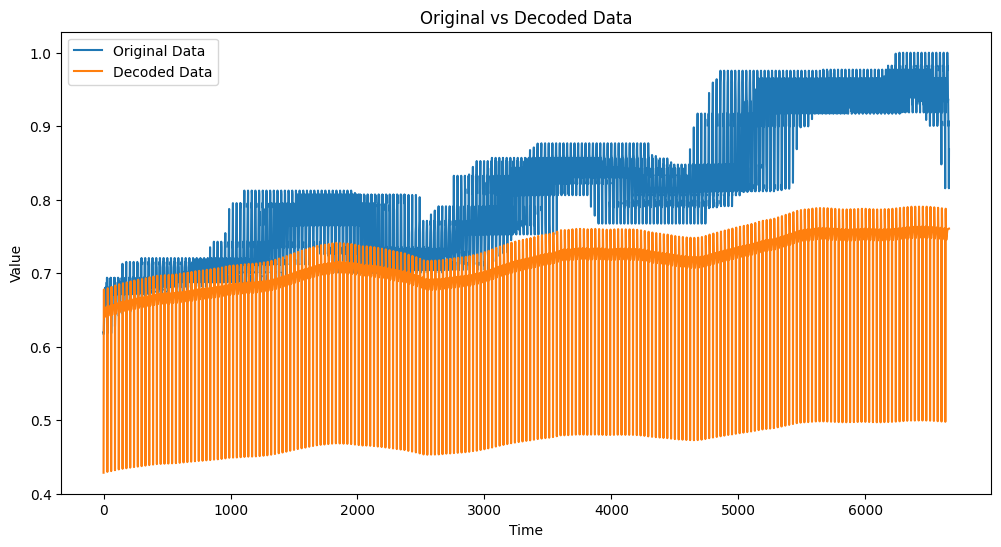

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Попробуем увеличить латентное пространство
latent_dim = 256
seq_length = 30
dropout_rate = 0.3

# Энкодер
encoder_inputs = Input(shape=(seq_length, 1))
encoder_lstm = LSTM(latent_dim, return_sequences=False, kernel_regularizer=l2(0.01))(encoder_inputs)
encoder_lstm = Dropout(dropout_rate)(encoder_lstm)
encoder_model = Model(encoder_inputs, encoder_lstm, name="encoder")

# Декодер
decoder_inputs = RepeatVector(seq_length)(encoder_lstm)
decoder_lstm = LSTM(latent_dim, return_sequences=True, kernel_regularizer=l2(0.01))(decoder_inputs)
decoder_lstm = Dropout(dropout_rate)(decoder_lstm)
decoder_outputs = TimeDistributed(Dense(1))(decoder_lstm)

# Автоэнкодер
autoencoder = Model(encoder_inputs, decoder_outputs, name="autoencoder")
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Обучение модели
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)

# Визуализация потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Предсказание на тестовых данных
decoded_data = autoencoder.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(X_test.reshape(-1, 1), label='Original Data')
plt.plot(decoded_data.reshape(-1, 1), label='Decoded Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original vs Decoded Data')
plt.legend()
plt.show()

**Попробуем другую архитектуру** и добавим регуляризацию

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 256)                 │         198,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_3 (RepeatVector)       │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 30, 256)             │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 30, 1)               │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 593,921 (2.27 MB)

 Trainable params: 593,921 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 2.9949 - val_loss: 1.0088
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7060 - val_loss: 0.1810
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1190 - val_loss: 0.0404
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0204 - val_loss: 0.0089
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0058 - val_loss: 0.0149
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - val_loss: 0.0065
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0277
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - val_loss: 0.0099


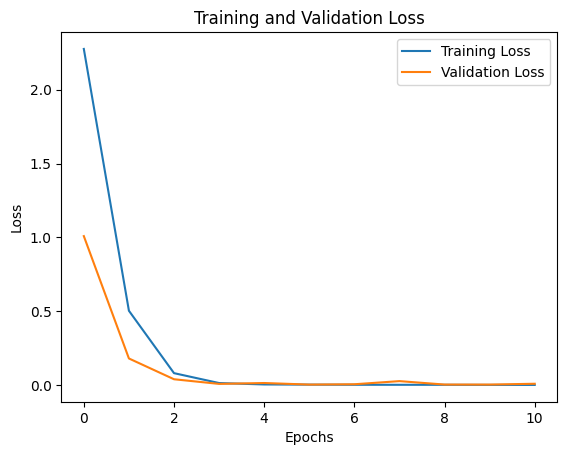

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


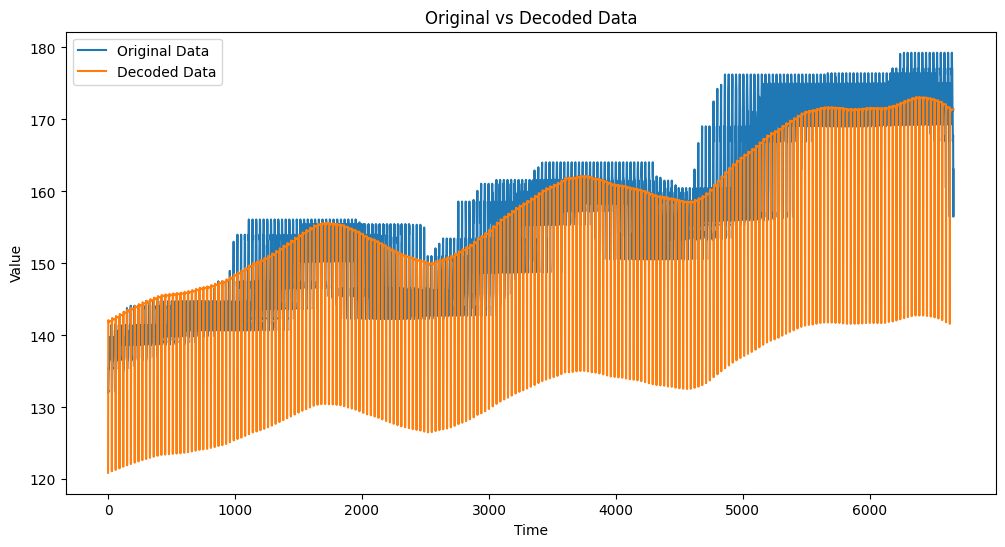

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Параметры модели
latent_dim = 256
seq_length = 30
dropout_rate = 0.3

# Энкодер
encoder_inputs = Input(shape=(seq_length, 1))
encoder_gru = GRU(latent_dim, return_sequences=False, kernel_regularizer=l2(0.01))(encoder_inputs)
encoder_gru = Dropout(dropout_rate)(encoder_gru)
encoder_model = Model(encoder_inputs, encoder_gru, name="encoder")

# Декодер
decoder_inputs = RepeatVector(seq_length)(encoder_gru)
decoder_gru = GRU(latent_dim, return_sequences=True, kernel_regularizer=l2(0.01))(decoder_inputs)
decoder_gru = Dropout(dropout_rate)(decoder_gru)
decoder_outputs = TimeDistributed(Dense(1))(decoder_gru)

# Автоэнкодер
autoencoder = Model(encoder_inputs, decoder_outputs, name="autoencoder")
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True )


history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)

# Визуализация
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Предсказание на тестовых данных
decoded_data = autoencoder.predict(X_test)


decoded_data = scaler.inverse_transform(decoded_data.reshape(-1, 1))
original_data = scaler.inverse_transform(X_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(original_data, label='Original Data')
plt.plot(decoded_data, label='Decoded Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original vs Decoded Data')
plt.legend()
plt.show()

**Попробуем стабилизировать модель с помощью BatchNormalization** и сделаем модель менее чувствительной к выбросам loss='mae'



Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)          │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_30 (GRU)                         │ (None, 256)                 │         198,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_25 (RepeatVector)      │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_31 (GRU)                         │ (None, 30, 256)             │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 30, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 30, 1)               │             257 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 595,969 (2.27 MB)

 Trainable params: 594,945 (2.27 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 5.0418 - val_loss: 4.4481
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.7363 - val_loss: 4.2387
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.4985 - val_loss: 4.0363
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.3095 - val_loss: 3.8508
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.1247 - val_loss: 3.6710
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.9543 - val_loss: 3.5113
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.8115 - val_loss: 3.3694
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.6682 - val_loss: 3.2204
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.5247 - val_loss: 3.1024
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3777 - val_loss: 2.9516
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.2460 - val_loss: 2.8202
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

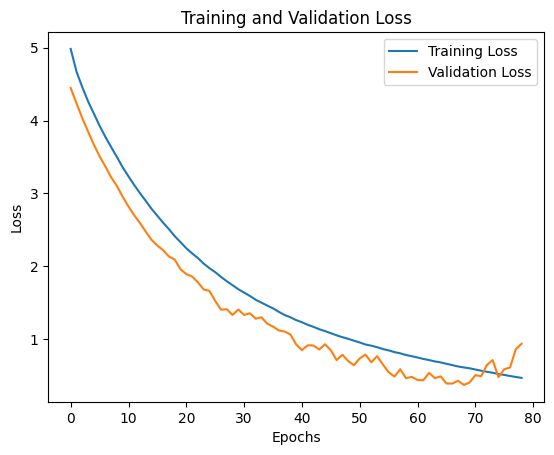

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


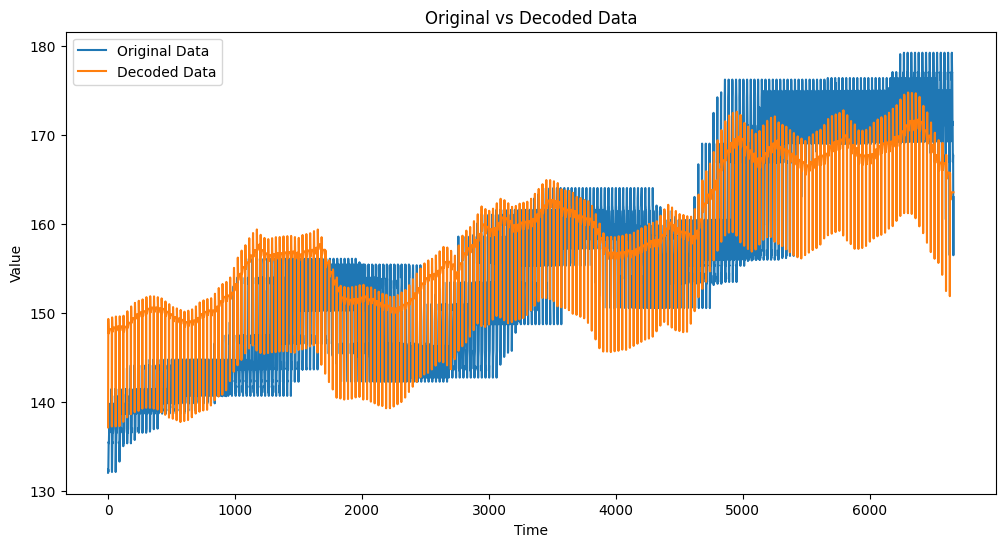

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, RepeatVector, TimeDistributed, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


latent_dim = 256
seq_length = 30
dropout_rate = 0.5

# Энкодер
encoder_inputs = Input(shape=(seq_length, 1))
encoder_gru = GRU(latent_dim, return_sequences=False, kernel_regularizer=l2(0.01))(encoder_inputs)
encoder_gru = BatchNormalization()(encoder_gru)
encoder_gru = Dropout(dropout_rate)(encoder_gru)
encoder_model = Model(encoder_inputs, encoder_gru, name="encoder")

# Декодер
decoder_inputs = RepeatVector(seq_length)(encoder_gru)
decoder_gru = GRU(latent_dim, return_sequences=True, kernel_regularizer=l2(0.01))(decoder_inputs)
decoder_gru = BatchNormalization()(decoder_gru)
decoder_gru = Dropout(dropout_rate)(decoder_gru)
decoder_outputs = TimeDistributed(Dense(1))(decoder_gru)

# Автоэнкодер
autoencoder = Model(encoder_inputs, decoder_outputs, name="autoencoder")
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')

autoencoder.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Обучение модели
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Предсказание на тестовых данных
decoded_data = autoencoder.predict(X_test)


decoded_data = scaler.inverse_transform(decoded_data.reshape(-1, 1))
original_data = scaler.inverse_transform(X_test.reshape(-1, 1))


plt.figure(figsize=(12, 6))
plt.plot(original_data, label='Original Data')
plt.plot(decoded_data, label='Decoded Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original vs Decoded Data')
plt.legend()
plt.show()

**Попробуем Bidirectional RNN**

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)          │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 512)                 │         397,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_94 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_41 (RepeatVector)      │ (None, 30, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ (None, 30, 512)             │       1,182,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 30, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_95 (Dropout)                 │ (None, 30, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_41                  │ (None, 30, 1)               │             513 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,585,153 (6.05 MB)

 Trainable params: 1,583,105 (6.04 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 13.5057 - val_loss: 12.4399
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 12.7070 - val_loss: 11.7802
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.0193 - val_loss: 11.1301
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 11.3877 - val_loss: 10.5348
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.7947 - val_loss: 9.9475
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.2675 - val_loss: 9.4378
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.7480 - val_loss: 8.9540
Epoch 8/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.2715 - val_loss: 8.4747
Epoch 9/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.8154 - val_loss: 8.0210
Epoch 10/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.3899 - val_loss: 7.6204
Epoch 11/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7.9869 - val_loss: 7.2252
Epoch 12/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

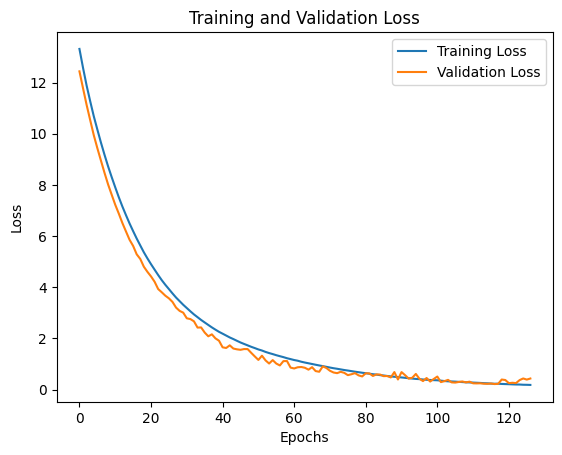

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


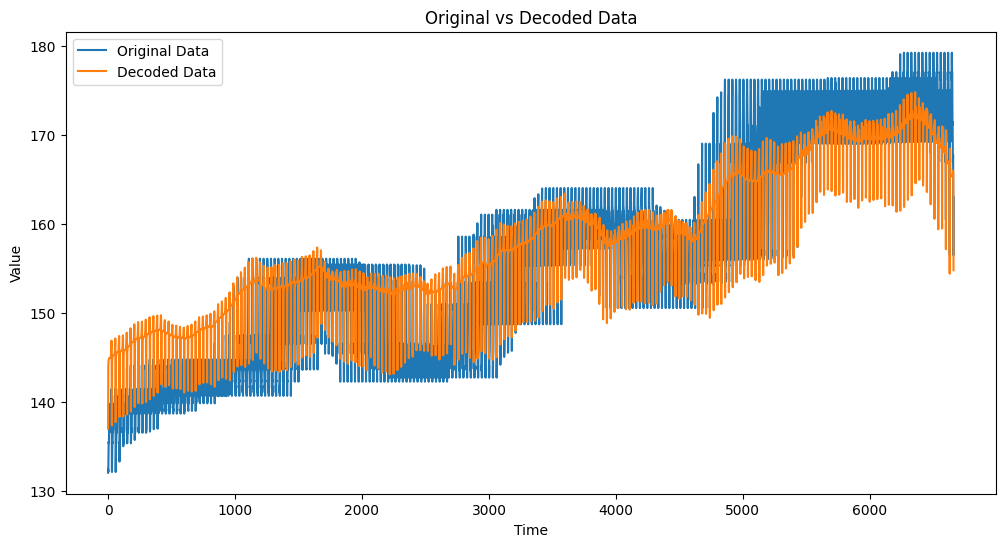

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, RepeatVector, TimeDistributed, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


latent_dim = 256
seq_length = 30
dropout_rate = 0.5
kernel_regularizer = l2(0.01)

# Энкодер
encoder_inputs = Input(shape=(seq_length, 1))
encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=False, kernel_regularizer=kernel_regularizer))(encoder_inputs)
encoder_gru = BatchNormalization()(encoder_gru)
encoder_gru = Dropout(dropout_rate)(encoder_gru)
encoder_model = Model(encoder_inputs, encoder_gru, name="encoder")

# Декодер
decoder_inputs = RepeatVector(seq_length)(encoder_gru)
decoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, kernel_regularizer=kernel_regularizer))(decoder_inputs)
decoder_gru = BatchNormalization()(decoder_gru)
decoder_gru = Dropout(dropout_rate)(decoder_gru)
decoder_outputs = TimeDistributed(Dense(1))(decoder_gru)

# Автоэнкодер
autoencoder = Model(encoder_inputs, decoder_outputs, name="autoencoder")
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')


autoencoder.summary()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history = autoencoder.fit(
    X_train, X_train,
    epochs=150,
    batch_size=64,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Предсказание на тестовых данных
decoded_data = autoencoder.predict(X_test)


decoded_data = scaler.inverse_transform(decoded_data.reshape(-1, 1))
original_data = scaler.inverse_transform(X_test.reshape(-1, 1))


plt.figure(figsize=(12, 6))
plt.plot(original_data, label='Original Data')
plt.plot(decoded_data, label='Decoded Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original vs Decoded Data')
plt.legend()
plt.show()

**Уже хорошо, но попробовала ещё VAE, результат ухудшился**

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38            │ (None, 30, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 512)            │        397,824 │ input_layer_38[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 512)            │          2,048 │ bidirectional_6[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_86 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_37          │ (None, 30, 512)        │              0 │ dropout_86[0][0]       │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_7           │ (None, 30, 512)        │      1,182,720 │ repeat_vector_37[0][0] │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 30, 512)        │          2,048 │ bidirectional_7[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_87 (Dropout)      │ (None, 30, 512)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_37       │ (None, 30, 1)          │            513 │ dropout_87[0][0]       │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 256)            │        131,328 │ dropout_86[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 256)            │        131,328 │ dropout_86[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vae_loss_layer_8          │ (None, 30, 1)          │              0 │ input_layer_38[0][0],  │
│ (VAELossLayer)            │                        │                │ time_distributed_37[0… │
│                           │                        │                │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,847,809 (7.05 MB)

 Trainable params: 1,845,761 (7.04 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 155.6045 - val_loss: 32.2032
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 122.0346 - val_loss: 29.6597
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 105.3873 - val_loss: 27.3525
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 97.2620 - val_loss: 26.1256
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 91.3574 - val_loss: 24.8031
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 87.3987 - val_loss: 23.5965
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 84.2433 - val_loss: 22.6777
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 80.7889 - val_loss: 22.0664
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 80.2218 - val_loss: 21.1646
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 78.8984 - val_loss: 19.6213
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 76.9818 - val_loss: 20.2808
Epoch 12/100
16/16 ━━━━━━━━

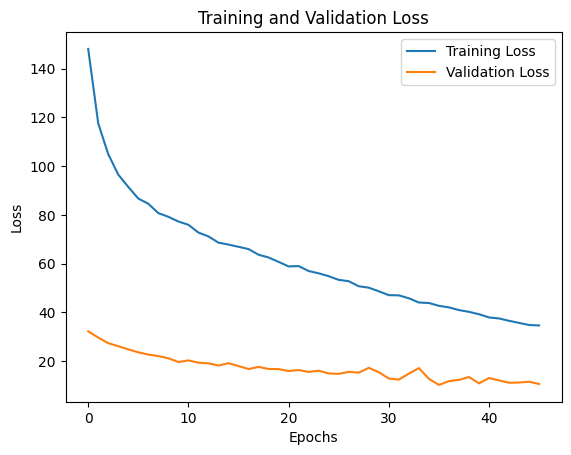

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


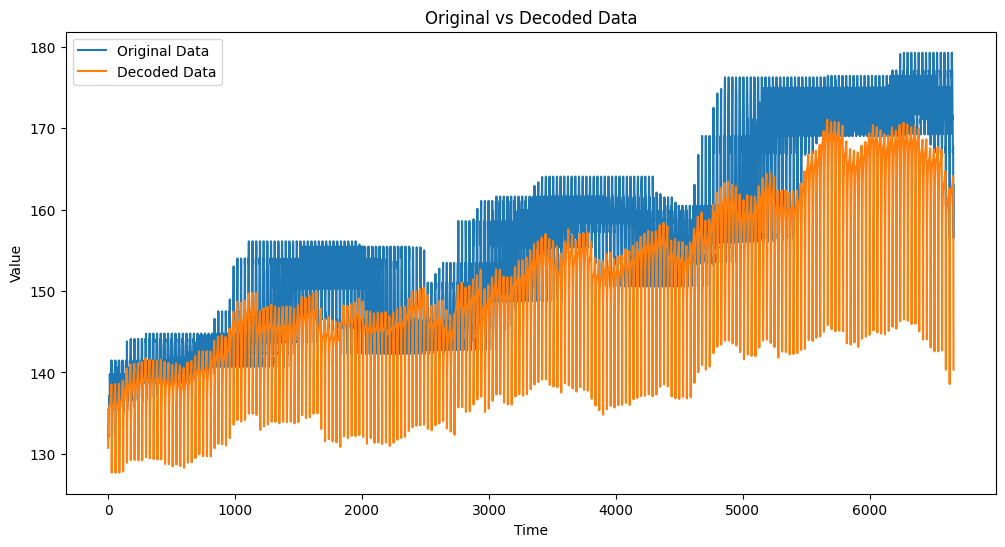

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, RepeatVector, TimeDistributed, Dense, Dropout, Lambda, Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt


latent_dim = 256
seq_length = 30
dropout_rate = 0.5
kernel_regularizer = l2(0.01)

# Энкодер
encoder_inputs = Input(shape=(seq_length, 1))
encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=False, kernel_regularizer=kernel_regularizer))(encoder_inputs)
encoder_gru = BatchNormalization()(encoder_gru)
encoder_gru = Dropout(dropout_rate)(encoder_gru)
encoder_model = Model(encoder_inputs, encoder_gru, name="encoder")


z_mean = Dense(latent_dim, name="z_mean")(encoder_gru)
z_log_var = Dense(latent_dim, name="z_log_var")(encoder_gru)


def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, name="z")([z_mean, z_log_var])

# Декодер
decoder_inputs = RepeatVector(seq_length)(encoder_gru)
decoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, kernel_regularizer=kernel_regularizer))(decoder_inputs)
decoder_gru = BatchNormalization()(decoder_gru)  # Добавляем BatchNormalization
decoder_gru = Dropout(dropout_rate)(decoder_gru)
decoder_outputs = TimeDistributed(Dense(1))(decoder_gru)


class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        inputs, outputs, z_mean, z_log_var = inputs

        # Ошибка восстановления
        reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
        reconstruction_loss *= seq_length

        # KL-дивергенция
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1) * -0.5

        # Общая ошибка
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(vae_loss)  # Добавляем потери


        return outputs

    def compute_output_shape(self, input_shape):
        return input_shape[1]

# Входные и выходные данные для слоя потерь
loss_inputs = [encoder_inputs, decoder_outputs, z_mean, z_log_var]
vae_outputs = VAELossLayer()(loss_inputs)


vae = Model(encoder_inputs, vae_outputs, name="vae")
vae.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')
vae.summary()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history = vae.fit(
    X_train, X_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Предсказание на тестовых данных
decoded_data = vae.predict(X_test)


decoded_data = scaler.inverse_transform(decoded_data.reshape(-1, 1))
original_data = scaler.inverse_transform(X_test.reshape(-1, 1))


plt.figure(figsize=(12, 6))
plt.plot(original_data, label='Original Data')
plt.plot(decoded_data, label='Decoded Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original vs Decoded Data')
plt.legend()
plt.show()